In [1]:
import random
from enum import Enum, unique
from typing import List

import matplotlib
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import yaml
from PIL import Image
from tensorboardX import SummaryWriter
from torch.multiprocessing import freeze_support
from torch.utils.data import DataLoader, Dataset
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed


sns.set_style()
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["font.family"] = "Rubik"
sns.set_context("paper")


from pit.dynamics.kinematic_bicycle import Bicycle
from pit.dynamics.unicycle import Unicycle
from pit.integration import Euler, RK4
from vmp.data_utils import get_map_points, TraceRelativeDataset, centerline, map_x, map_y
from vmp.utils import Method, DynamicModel, Curvature, frenet_to_point, point_to_frenet, get_interpolated_point
from vmp.viz_utils import create_debug_plot, create_single_plot
from vmp.networks import LSTMPredictorPCMP, LSTMPredictor, get_model
from vmp.losses import *
from vmp.data_utils import TraceRelativeDataset, TRAIN_LIST, VAL_LIST, TEST_LIST, RACE_TEST_LIST, map_x, map_y, CAR_LENGTH, CAR_WIDTH
from toy_problem_library import test_model

In [2]:
def rad_to_deg(radians):
    return radians*57.29578

In [3]:
DEVICE = 'cuda:1'

In [54]:
train_frame = pd.read_pickle("../../data/train_data.pkl")
val_frame = pd.read_pickle("../../data/val_data.pkl")
test_frame = pd.read_pickle("../../data/test_data.pkl")
full_frame = pd.read_pickle("../../data/final_data.pkl")
no_race_val_frame = val_frame[
    val_frame["selected_lane"].apply(
        lambda x: True if x in ["left", "center", "right"] else False
    )
]
race_val_frame = val_frame[
    val_frame["selected_lane"].apply(
        lambda x: True if x in ["race"] else False
    )
]
no_race_test_frame = test_frame[
    test_frame["selected_lane"].apply(
        lambda x: True if x in ["left", "center", "right"] else False
    )
]
race_test_frame = full_frame[
    full_frame["selected_lane"].apply(lambda x: True if x in ["race"] else False)
]

In [55]:
train_dataset = TraceRelativeDataset(train_frame, curve=True, random_noise=True)
test_dataset = TraceRelativeDataset(test_frame, curve=True, random_noise=True)
val_dataset = TraceRelativeDataset(val_frame, curve=True, random_noise=True)
no_race_val_dataset = TraceRelativeDataset(no_race_val_frame, curve=True, random_noise=True)
race_val_dataset = TraceRelativeDataset(race_val_frame, curve=True, random_noise=True)
no_race_test_dataset = TraceRelativeDataset(no_race_test_frame, curve=True, random_noise=True)
race_test_dataset = TraceRelativeDataset(race_test_frame, curve=True, random_noise=True)
#debug_dataset = TraceRelativeDataset(val_frame[:512], curve=True)
#debug_dataloader = DataLoader(debug_dataset, batch_size=512, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=True)
no_race_val_dataloader = DataLoader(no_race_val_dataset, batch_size=1024, shuffle=True)
race_val_dataloader = DataLoader(race_val_dataset, batch_size=1024, shuffle=True)
no_race_test_dataloader = DataLoader(no_race_test_dataset, batch_size=1024, shuffle=True)
race_test_dataloader = DataLoader(race_test_dataset, batch_size=1024, shuffle=True)

In [56]:
path_root = "runs/final-toy/performance-comparison/PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-5/"
#path_root = "runs/final-toy/performance-comparison/LSTM-CURVATURE-16-P6044-NOCURR-DISPLOSS/"

meta = torch.load(path_root+"last_model_meta.pt")
config = meta['config']
net, optimizer, directory, config_dict = get_model(config)
config_dict["DEVICE"] = DEVICE
net.load_state_dict(torch.load(path_root+"last_model.pt"))
net.to(DEVICE)
net.eval()
for input, last_pose, target in train_dataloader:
    break
display(input.shape)
display(last_pose.shape)
display(target.shape)
input = input.to(DEVICE)
last_pose = last_pose.to(DEVICE)
other_outp, other_outp_control = net.predict(input, last_pose)
#other_outp = net.predict(input, last_pose)
other_outp.shape

torch.Size([1024, 10, 10])

torch.Size([1024, 4])

torch.Size([1024, 60, 3])

torch.Size([1024, 60, 4])

In [57]:
meta['epoch']

349

In [58]:
meta['config']

{'hidden_dim': 16,
 'epochs': 350,
 'control_outputs': 60,
 'curriculum': True,
 'eps_per_input': 2,
 'prefix': 'runs/final-toy/performance-comparison/',
 'batch_size': 512,
 'DEVICE': 'cuda:1',
 'wheelbase': 0.3302,
 'residual': False,
 'model': <DynamicModel.BICYCLE: 0>,
 'robustness': False,
 'wd': 1e-05,
 'lr': 0.001,
 'momentum': 0.8,
 'horizon': 60,
 'timestep': 0.01,
 'loss_func': 'custom',
 'save_all': True,
 'method': <Method.PIMP: 0>,
 'curvature': <Curvature.CURVATURE: 1>,
 'job_id': 5,
 'output_queue': None,
 'pytorch_total_params': 5505}

0.933387041091919

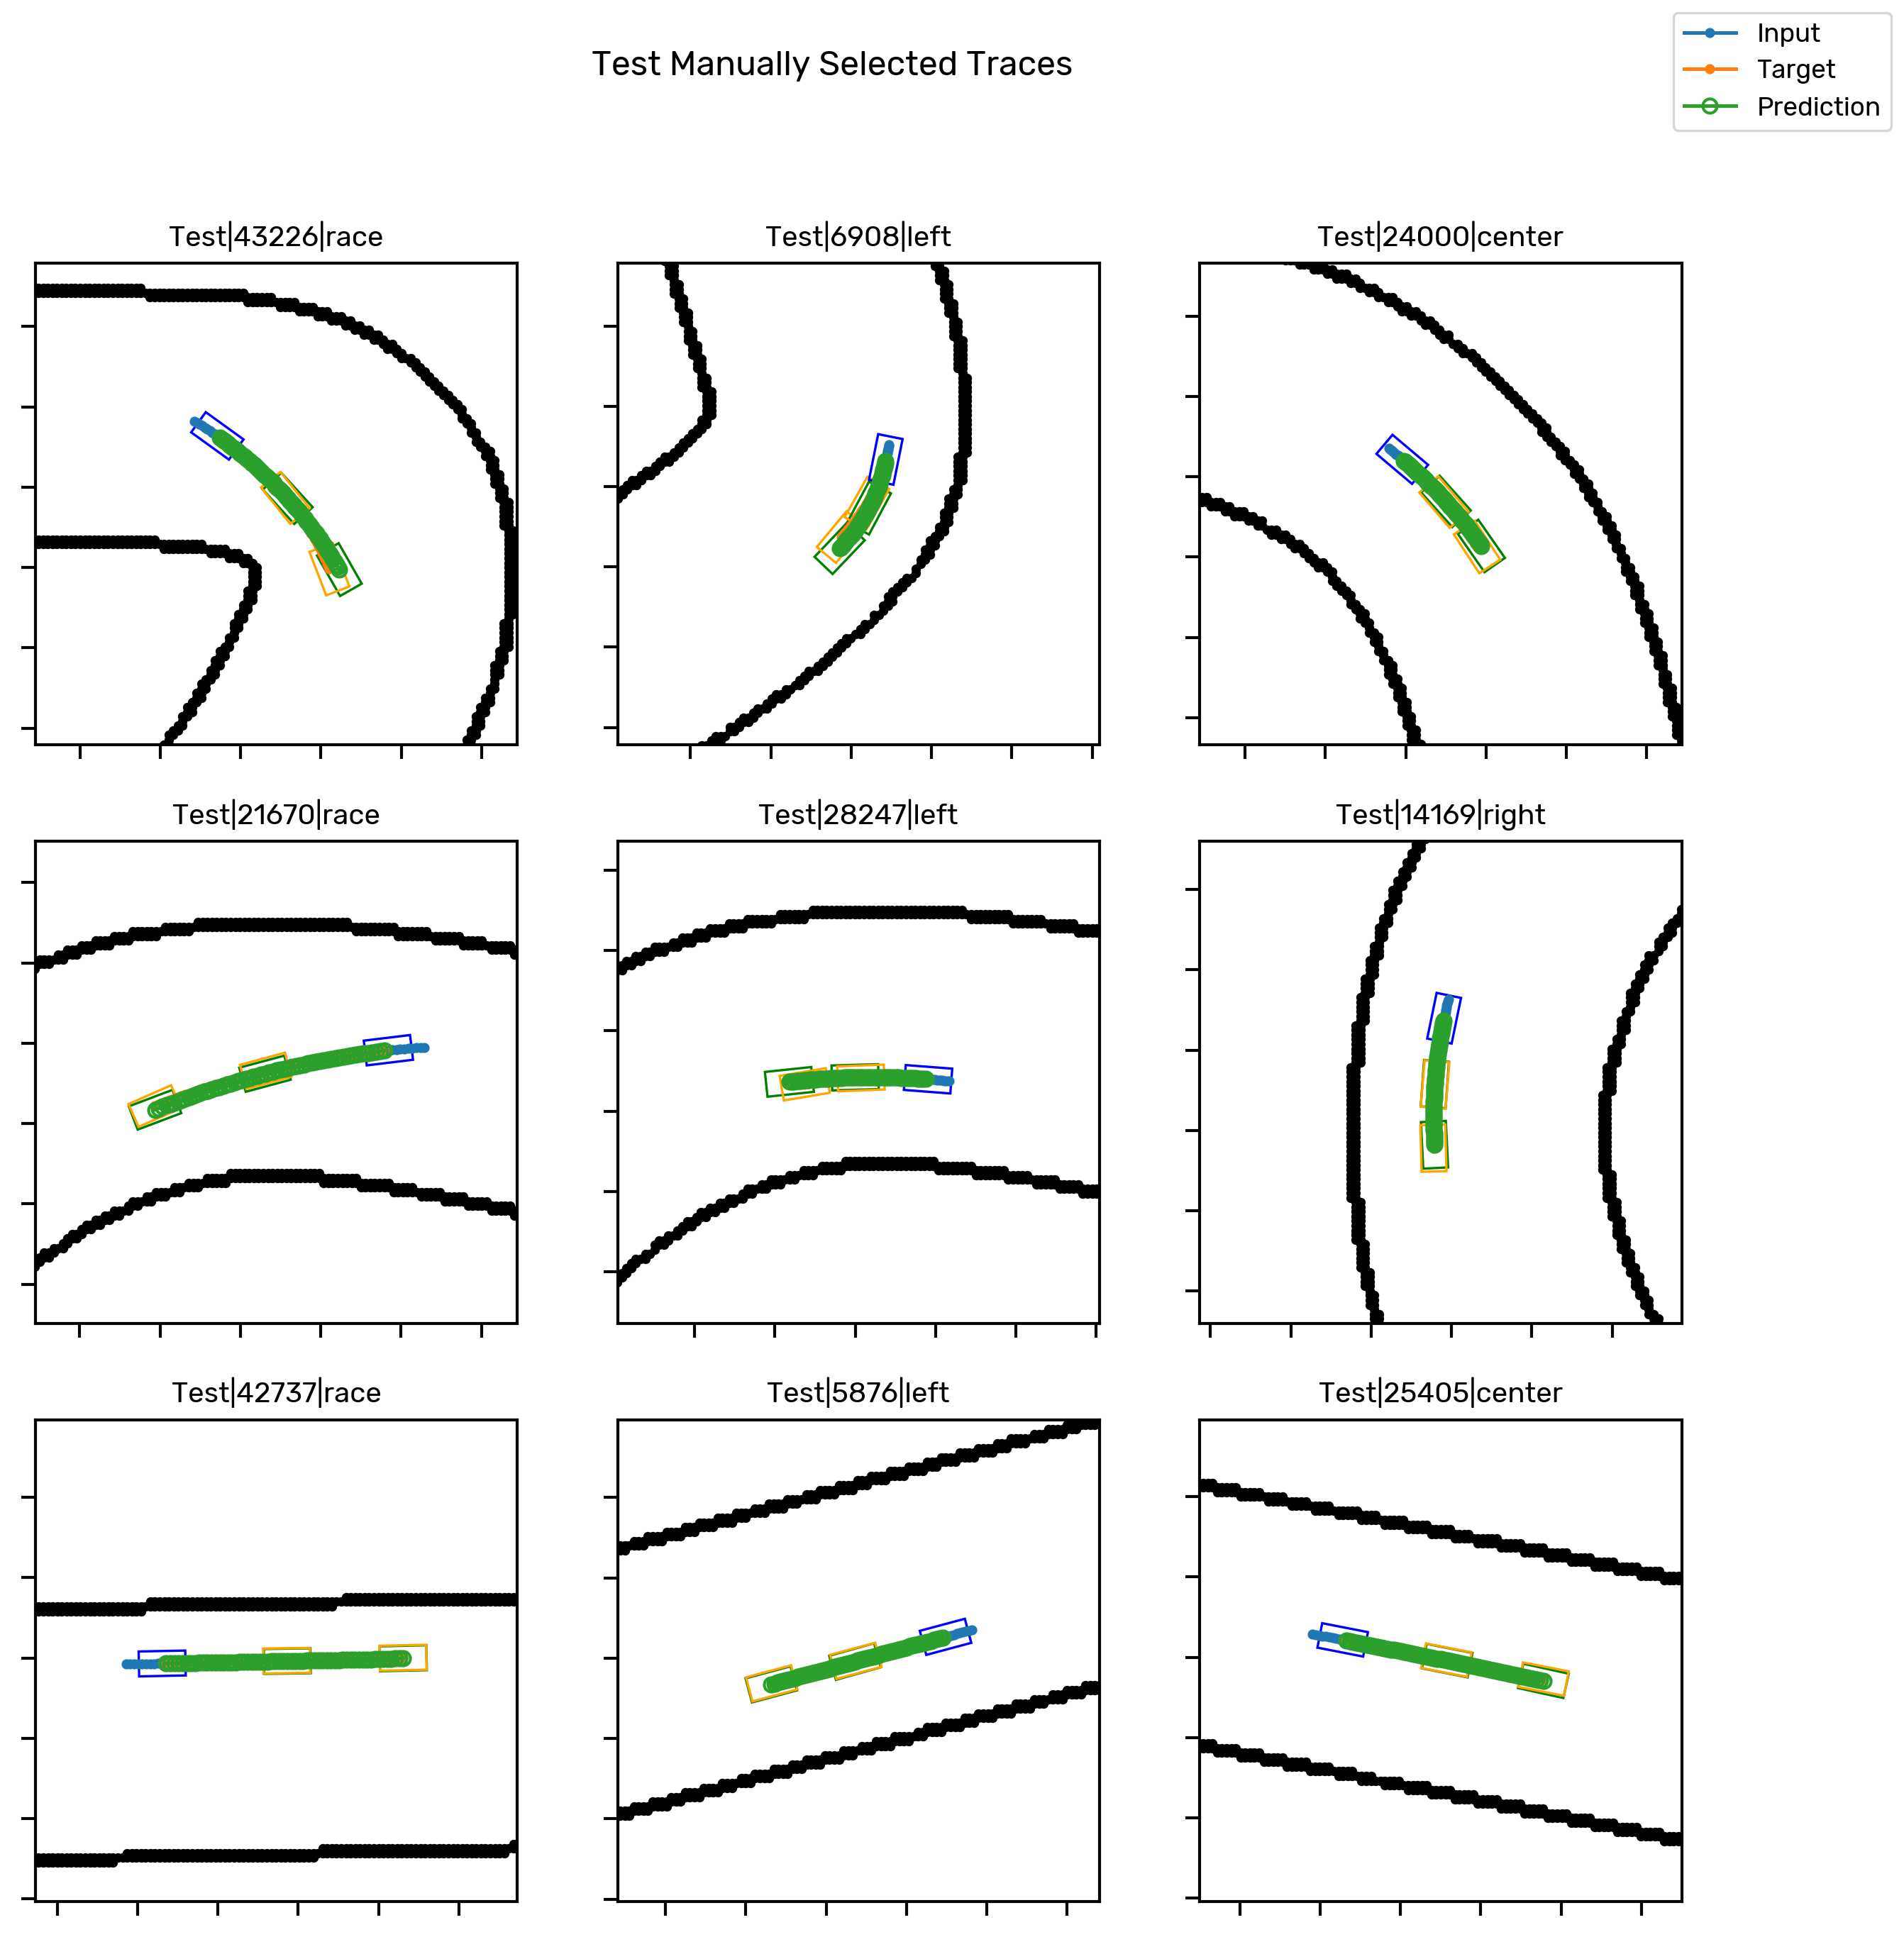

In [59]:
import time
start = time.time()
create_debug_plot(
    net, 
    train_dataset=train_dataloader.dataset, 
    test_dataset=test_dataloader.dataset, 
    val_dataset=val_dataloader.dataset, 
    curvature=config['curvature'], 
    DEVICE=DEVICE, 
    full_frame=full_frame, 
    dataset_name="test"
)
end = time.time()
end-start

In [61]:
def get_metric_distribution(path, samples=30, dataloader=test_dataloader, dataset_name='test'):
    from vmp.utils import set_seed
    meta = torch.load(path+"last_model_meta.pt")
    config = meta['config']
    net, optimizer, directory, config_dict = get_model(config)
    config_dict["DEVICE"] = DEVICE
    net.load_state_dict(torch.load(path+"last_model.pt"))
    net.to(DEVICE)
    net.eval()

    ades = list()
    fdes = list()
    head_errs = list()
    iou_errs = list()

    for i in tqdm(range(samples)):
        ade, fde, cum_head_err, iou_err, cum_test_loss, test_fig, end_index, element_results = test_model(
            config_dict=config_dict,
            net=net,
            dataloader=dataloader,
            loss_func=custom_loss_func,
            epoch=350,
            curriculum_steps=1,
            dataset_name=dataset_name,
            histogram_results=True,
            iou=True,
            image=False,
            seed=i,
        )
        ades.append(ade)
        fdes.append(fde)
        head_errs.append(cum_head_err)
        iou_errs.append(iou_err)
    return {
        'path': path,
        'ades': ades,
        'fdes': fdes,
        'heading_errors': head_errs,
        'iou_errors': iou_errs,
        'training_loss': meta['train_losses'][-1],
    }


In [11]:
get_metric_distribution("runs/final-toy/performance-comparison/CTRV-60-P0-0.001-0/", 3)

  0%|          | 0/3 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in

{'path': 'runs/final-toy/performance-comparison/CTRV-60-P0-0.001-0/',
 'ades': [0.2553160058616272, 0.25940698715153654, 0.25606386423990735],
 'fdes': [0.7354921362056943, 0.747640307099177, 0.737071209728058],
 'heading_errors': [0.009171528129999927,
  0.009273009546568473,
  0.01055760929065437],
 'iou_errors': [0.43664335060823445, 0.4334131219730166, 0.4405309775658639]}

In [12]:
get_metric_distribution("runs/final-toy/performance-comparison/PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-5/", 3)

  0%|          | 0/3 [00:00<?, ?it/s]

{'path': 'runs/final-toy/performance-comparison/PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-5/',
 'ades': [0.0457177650444622, 0.04541954739067387, 0.04526957154713873],
 'fdes': [0.1070133170518488, 0.10659871242143132, 0.10620652001722272],
 'heading_errors': [0.002291240842799859,
  0.0022220274509099137,
  0.0023530177579594714],
 'iou_errors': [0.7960787804804165, 0.7966775823783171, 0.7974734886985864]}

In [53]:
from joblib import Parallel, delayed
import datetime
jobs = [
    "runs/final-toy/performance-comparison/PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-5/",
    "runs/final-toy/performance-comparison/PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-4/",
    "runs/final-toy/performance-comparison/LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-2/",
    "runs/final-toy/performance-comparison/CTRV-60-P0-0.001-0/"
]
#results = Parallel(n_jobs=5, verbose=10)(delayed(get_metric_distribution)(i, 3) for i in jobs)
results =[get_metric_distribution(i) for i in jobs]

#pimp_curr_2 = get_metric_distribution("runs/final-toy/performance-comparison/PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS/")
#pimp_no_curr = get_metric_distribution("runs/final-toy/performance-comparison/PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS/")
#lstm = get_metric_distribution("runs/final-toy/performance-comparison/LSTM-CURVATURE-16-P6044-NOCURR-DISPLOSS/")
results

  0%|          | 0/30 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[{'path': 'runs/final-toy/performance-comparison/PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-5/',
  'ades': [0.0457177650444622,
   0.04541954739067387,
   0.04526957154713873,
   0.04530735297396614,
   0.04548563574512946,
   0.045401981835875564,
   0.04527789794211018,
   0.04537943984309686,
   0.0454481470628858,
   0.04564645919412704,
   0.045290101058368754,
   0.045275132594513275,
   0.04546681761301752,
   0.045485780687789634,
   0.045639311255564106,
   0.045372451803341124,
   0.04548164421341956,
   0.04521155159411835,
   0.04499615954297055,
   0.04552299158159657,
   0.04557611097708839,
   0.045621197601965875,
   0.04521527413512508,
   0.04521969499623204,
   0.04529802121799371,
   0.04548858936422426,
   0.045390599328213516,
   0.04543942345024475,
   0.04526467736796699,
   0.045174147810003416],
  'fdes': [0.1070133170518488,
   0.10659871242143132,
   0.10620652001722272,
   0.10642762553647875,
   0.10660548491671516,
   0.106519741325

In [14]:
import pathlib
for res in results:
    res['name'] = pathlib.PurePath(res['path']).name

In [15]:
str(results[0]['name'])

'PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-5'

In [16]:
[res['name'] for res in results]

['PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-5',
 'PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-4',
 'LSTM-CURVATURE-16-P6044-NOCURR-DISPLOSS-3',
 'LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-2',
 'CTRV-60-P0-0.001-0']

In [17]:
from scipy import stats

<AxesSubplot: >

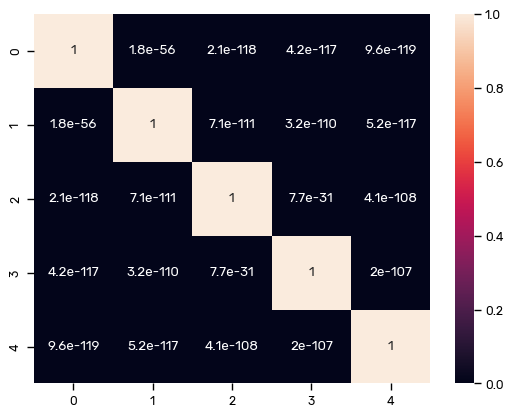

In [18]:
metric = 'iou_errors'
statistics = np.zeros((5, 5))
pvalues = np.zeros((5, 5))
for i in range(5):
    for j in range(5):
        stat, pval = stats.ttest_ind(results[i][metric], results[j][metric])
        statistics[i, j] = stat
        pvalues[i, j] = pval
sns.heatmap(pvalues, annot=True)

<AxesSubplot: >

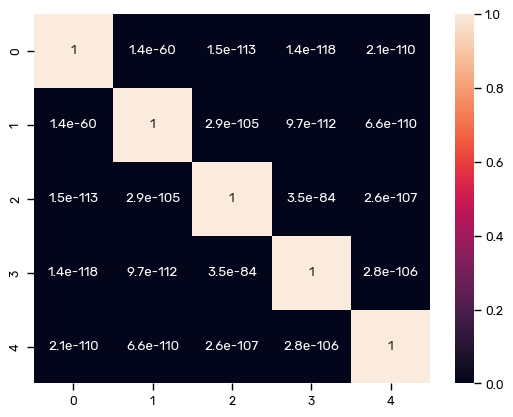

In [19]:
metric = 'ades'
statistics = np.zeros((5, 5))
pvalues = np.zeros((5, 5))
for i in range(5):
    for j in range(5):
        stat, pval = stats.ttest_ind(results[i][metric], results[j][metric])
        statistics[i, j] = stat
        pvalues[i, j] = pval
sns.heatmap(pvalues, annot=True)

<AxesSubplot: >

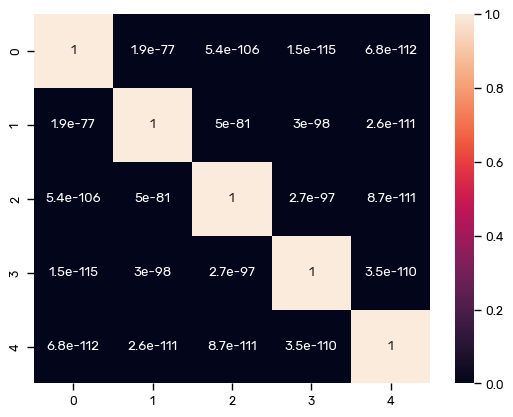

In [20]:
metric = 'fdes'
statistics = np.zeros((5, 5))
pvalues = np.zeros((5, 5))
for i in range(5):
    for j in range(5):
        stat, pval = stats.ttest_ind(results[i][metric], results[j][metric])
        statistics[i, j] = stat
        pvalues[i, j] = pval
sns.heatmap(pvalues, annot=True)

In [49]:
metric='ades'
print(metric)
for res in results[::-1]:
    print(f"{res['name']:<70}  MEAN: {np.mean(res[metric]):4f}  STDDEV: {np.std(res[metric]):4e}")

ades
CTRV-60-P0-0.001-0                                                      MEAN: 0.256831  STDDEV: 1.991313e-03
LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-2                             MEAN: 0.077409  STDDEV: 1.493781e-04
LSTM-CURVATURE-16-P6044-NOCURR-DISPLOSS-3                               MEAN: 0.070030  STDDEV: 1.293480e-04
PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-4     MEAN: 0.049172  STDDEV: 2.042718e-04
PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-5     MEAN: 0.045393  STDDEV: 1.596685e-04


In [50]:
metric='fdes'
print(metric)
for res in results[::-1]:
    print(f"{res['name']:<70}  MEAN: {np.mean(res[metric]):4f}  STDDEV: {np.std(res[metric]):4e}")

fdes
CTRV-60-P0-0.001-0                                                      MEAN: 0.740009  STDDEV: 5.637244e-03
LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-2                             MEAN: 0.148457  STDDEV: 1.709833e-04
LSTM-CURVATURE-16-P6044-NOCURR-DISPLOSS-3                               MEAN: 0.134202  STDDEV: 1.488890e-04
PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-4     MEAN: 0.120239  STDDEV: 3.969629e-04
PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-5     MEAN: 0.106442  STDDEV: 2.748198e-04


In [51]:
metric='iou_errors'
print(metric)
for res in results[::-1]:
    print(f"{res['name']:<70}  MEAN: {np.mean(res[metric]):4f}  STDDEV: {np.std(res[metric]):4e}")

iou_errors
CTRV-60-P0-0.001-0                                                      MEAN: 0.436441  STDDEV: 2.339130e-03
LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-2                             MEAN: 0.664445  STDDEV: 6.368628e-04
LSTM-CURVATURE-16-P6044-NOCURR-DISPLOSS-3                               MEAN: 0.667958  STDDEV: 5.205799e-04
PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-4     MEAN: 0.782545  STDDEV: 9.265747e-04
PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-5     MEAN: 0.797034  STDDEV: 7.190754e-04


In [24]:
stats.ttest_ind(results[0]['iou_errors'], results[4]['iou_errors'])

Ttest_indResult(statistic=793.5144341068172, pvalue=9.603843762938642e-119)

In [25]:
stats.ttest_ind(results[0]['iou_errors'], results[3]['iou_errors'])

Ttest_indResult(statistic=743.3390845242817, pvalue=4.242500749035088e-117)

In [26]:
stats.ttest_ind(results[0]['iou_errors'], results[2]['iou_errors'])

Ttest_indResult(statistic=782.9997961158676, pvalue=2.081703172482587e-118)

In [27]:
stats.ttest_ind(results[0]['iou_errors'], results[1]['iou_errors'])

Ttest_indResult(statistic=66.52680508819124, pvalue=1.8311052391192749e-56)

In [28]:
stats.ttest_ind(results[0]['iou_errors'], results[0]['iou_errors'])

Ttest_indResult(statistic=0.0, pvalue=1.0)